# Glacier ice dynamics toy model

Toy model based on the Shallow Ice Approximation (SIA), mixing
partial differential equations (PDEs), neural networks and model
interpretation using SINDy.
=#

In [1]:
## Environment and packages
#cd(@__DIR__)
#using Pkg; Pkg.activate("."); Pkg.instantiate()
using Infiltrator
#using Debugger

# using Flux, DiffEqFlux, DataDrivenDiffEq
# using Flux: @epochs
# using Zygote
using Plots
using Measures
gr()
using Base: @kwdef
using Statistics
using ModelingToolkit
using LinearAlgebra
using CartesianGrids
using HDF5
# Set a random seed for reproduceable behaviour
using Random

### Types

In [2]:
# what is the difference between using @kwdef and using the default constructor?

@kwdef mutable struct Hyperparameters
    batchsize::Int = 500     # batch size
    η::Float64 = 0.1         # learning rate
    epochs::Int = 500        # number of epochs
    use_cuda::Bool = true    # use gpu (if cuda available)
end

mutable struct Glacier
    bed::Array{Float32}    # bedrock height
    thick::Array{Float32}  # ice thickness
    vel::Array{Float32}    # surface velocities
end

### Functions

In [18]:
# 4 point average of Dual Nodes to a single Primal Node
function four_point_avg!(Nodes_4p_avg::Nodes{Primal}, dualNodes::Nodes{Dual}, i,j)
    Nodes_4p_avg[i,j] = (dualNodes[i,j] + dualNodes[i+1,j] + dualNodes[i,j+1] + dualNodes[i+1,j+1])/4
end

# Performs a 4 point average of Node values of the Dual grid to the Primal grid
function dual2primal_4p_avg!(primalNodes::Nodes{Primal}, dualNodes::Nodes{Dual})
    for i in 1:size(primalNodes)[1]
        for j in 1:size(primalNodes)[2]
            four_point_avg!(primalNodes, dualNodes, i,j)
        end
    end
end

# Squared norm of a gradient field
function ∇_norm²(gradEdges::Edges{Dual}, dualNodes::Nodes{Dual})
    ∇_norm² = Nodes(Primal, dualNodes)
    for i in 1:size(∇_norm²)[1]
        for j in 1:size(∇_norm²)[2]
            # 2-point mean of gradients
            u̅ = mean([gradEdges.u[i,j], gradEdges.u[i,j+1]])
            v̅ = mean([gradEdges.v[i,j], gradEdges.v[i+1,j]])
            # Squared norm
            ∇_norm²[i,j] = norm([u̅, v̅])^2
        end
    end

    return ∇_norm²
end

# Compute diffusivities on u and v
function diffusivity(vars, p)
    A, ρ, g, n = p
    H, ∇S_norm² = vars
    D = ((2*A)/(n+2)).*((ρ*g.*H).^n).*(H.^2).*(∇S_norm².^(n-1))
    # Diffusivities Nodes
    D_pn = Nodes(Primal,dem_dn)
    D_pn .= D

    return D_pn
end

diffusivity (generic function with 1 method)

### Load the data

- Do we have the lat/lon of each pixel/entry of the matrices? If not, it could be useful to include them in `Glacier`

In [16]:
# Load the HDF5 file with Harry's simulated data
root_dir = pwd()
argentiere_f = h5open(joinpath(root_dir, "data/Argentiere_2003-2100_aflow2e-16_50mres.h5"), "r")

🗂️ HDF5.File: (read-only) /Users/facundosapienza/Dropbox/Glacier UDE/odinn_toy/data/Argentiere_2003-2100_aflow2e-16_50mres.h5
├─ 🔢 bed
├─ 🔢 thick_hist
└─ 🔢 vel_hist

In [3]:
# Fill the Glacier structure with the retrieved data
argentiere = Glacier(HDF5.read(argentiere_f["bed"])[begin:end-2,:],
                     HDF5.read(argentiere_f["thick_hist"])[begin:end-2,:,:],
                     HDF5.read(argentiere_f["vel_hist"])[begin:end-2,:,:])

In [15]:
typeof(argentiere.bed)

Matrix{Float32} (alias for Array{Float32, 2})

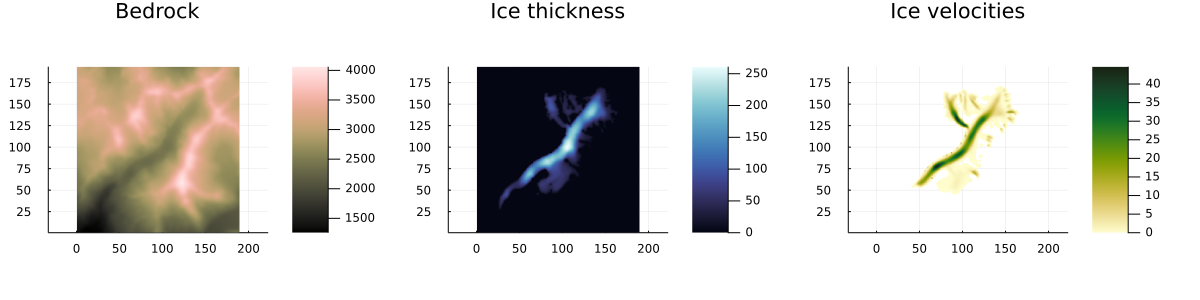

In [11]:
# Argentière bedrock
hm01 = heatmap(argentiere.bed, c = :turku, title="Bedrock")
# Argentière ice thickness for an individual year
hm02 = heatmap(argentiere.thick[:,:,1], c = :ice, title="Ice thickness")
# Surface velocities
hm03 = heatmap(argentiere.vel[:,:,15], c = :speed, title="Ice velocities")
hm0 = plot(hm01,hm02,hm03, layout=(1,3), aspect_ratio=:equal, size=(1200,300))
display(hm0)

In [19]:
# Initial parameters
arg_dem = copy(argentiere.bed) .+ copy(argentiere.thick[:,:,1]) 
p = (2e-16, 900, 9.81, 3) # A, ρ, g, n
# Spatial and temporal differentials
Δx = 50 #m
Δt = 0.05 #years

####################################
##### Create staggered grid  #######
####################################

# Ice thickness
thick_dn = Nodes(Dual,size(argentiere.thick[:,:,1]))
thick_dn .= argentiere.thick[:,:,1]
thick_pn = Nodes(Primal, thick_dn)

# DEM
dem_dn = Nodes(Dual,size(arg_dem))
dem_dn .= arg_dem
dem_pn = Nodes(Primal,dem_dn)

# Forward model with Δt timestepping
for t in 0:Δt:10

    #####################################################
    #### 1 - Calculate diffusivities in Primal grid  ####
    #####################################################
    #println("Calculating diffusivities in Primal Nodes \n")

    # 1.1: 4-point average of ice thickness from Dual to Primal  
    dual2primal_4p_avg!(thick_pn, thick_dn)
    dual2primal_4p_avg!(dem_pn, dem_dn)

    # 1.2: 2-point central estimate of surface gradient from Dual Nodes to Dual Edges
    ∇_S_de = grad(dem_dn)/Δx

    # 1.3: 2-point average of squared norm of gradients from Dual Edges to Primal Nodes
    ∇S_norm² = ∇_norm²(∇_S_de, dem_dn)

    # 1.4: Calculate diffusivities on Primal Nodes
    vars = thick_pn, ∇S_norm²
    D_pn = diffusivity(vars, p)

    #####################################################
    ####   2 - Update ice thicknesses on Dual Nodes  ####
    #####################################################
    #println("Calculating flux divergence on Dual Nodes \n")

    # 2.1: 2-point average of diffusivity from Primal Nodes to Dual Edges
    D_de = Edges(Dual, ∇_S_de)
    grid_interpolate!(D_de.u, D_pn)
    grid_interpolate!(D_de.v, D_pn)

    # 2.2: 2-point central estimate of surface gradient from Dual Nodes to Dual Edges
    grad_de

    # 2.3: 2-point central estimate of flux divergence from Dual Edges to Dual Nodes
    # Computation of flux (F) on Dual Edges
    F_de = Edges(Dual, D_de)
    F_de.u .= D_de.u.*∇_S_de.u # F = D*∂S/∂x 
    F_de.v .= D_de.v.*∇_S_de.v # F = D*∂S/∂y
    # Computation of flux divergence on Dual Nodes
    F_dn = Nodes(Dual, dem_dn)
    divergence!(F_dn, F_de)

    # Compute ice flux for Δt
    F_dn *= Δt
    #F_dn /= 1000
    # Apply ice flux
    thick_dn +=F_dn
    dem_dn +=F_dn

    #vel_dn = Nodes(Dual, F_dn)
    vel_dn = F_dn.data./thick_dn.data

    ##################################################
    ###### Plot glacier evolution for each year  #####
    ##################################################
    if(t%1 == 0)
    #if(true)
        println(t)
        hm11 = heatmap(dem_dn.data, c = :turku, title="DEM")
        hm12 = heatmap(thick_dn.data, c = :ice, title="Ice thickness")
        hm13 = heatmap(F_dn.data, title="Flux divergence")
        hm14 = heatmap(vel_dn, c = :speed, title="Ice velocities")
        hm1 = plot(hm11,hm12,hm13,hm14, layout=4, aspect_ratio=:equal, size=(1000,600), plot_title=t)
        display(hm1)
    end

end

LoadError: UndefVarError: grad_de not defined